In [1]:
import collections
import functools
import statistics
from typing import Callable, Iterator, List, Optional, Tuple

import matplotlib.pyplot as plt
import nest_asyncio
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_federated as tff
from mizani.breaks import date_breaks
from mizani.formatters import date_format
from plotnine import *
from surprise import SVD
from surprise import Dataset, Reader
from surprise.model_selection import cross_validate

# Table of Contents

- [Step 1](#Step-1)
- [Step 2](#Step-2-+-Step-3)
- [Step 3](#Step-2-+-Step-3)
 * [Substep: EDA](#Substep:-EDA)
- [Step 4](#Step-4)
- [Step 5](#Step-5)
- [Step 6](#Step-6)
- [Step 7](#Step-7)
- [Step 8](#Step-8)
- [Step 9](#Step-9)
- [Step 10](#Step-10)

In [2]:
def inspect_df(df: pd.DataFrame, n: int = 5) -> pd.DataFrame:
    """Helper method to easily inspect DataFrames."""

    print(f"shape: {df.shape}")

    return df.head(n)

In [3]:
# disclaimer: may not work as is in Windows OS
# dataset source: https://grouplens.org/datasets/movielens/
!wget --backups=1 https://files.grouplens.org/datasets/movielens/ml-latest-small.zip -P data/

--2022-03-20 23:06:56--  https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘data/ml-latest-small.zip’

ml-latest-small.zip 100%[===================>] 955.28K   259KB/s    in 3.7s    

2022-03-20 23:07:00 (259 KB/s) - ‘data/ml-latest-small.zip’ saved [978202/978202]



In [4]:
# disclaimer: may not work as is in Windows OS
# if `unzip` does not exist in your system: apt-get install unzip
!unzip -o data/ml-latest-small.zip -d data/

Archive:  data/ml-latest-small.zip
  inflating: data/ml-latest-small/links.csv  
  inflating: data/ml-latest-small/tags.csv  
  inflating: data/ml-latest-small/ratings.csv  
  inflating: data/ml-latest-small/README.txt  
  inflating: data/ml-latest-small/movies.csv  


## Step 1

The prediction $r_{ui}$ is set as:

$$ r_{ui} = \mu + b_u + b_i + q_{i}^T p_u$$

If user $u$ is unknown, then the bias $b_u$ and the factors $p_u$ are assumed to be zero. 

The same applies for item $i$ with $b_i$ and $q_i$.

To estimate all the unknown, we minimize the following regularized squared error:

$$ \sum_{r_{ui} \in R_{train}} (r_{ui} - \hat{r_{ui}})^2 + \lambda (b_i^2 + b_u^2 + ||q_i||^2 + ||p_u||^2)$$

The minimization is performed by a stochastic gradient descent:

$$ b_u \leftarrow b_u + \gamma (e_{ui} - \lambda b_u)$$
$$ b_i \leftarrow b_i + \gamma (e_{ui} - \lambda b_i)$$
$$ p_u \leftarrow p_u + \gamma (e_{ui} q_i - \lambda p_u)$$
$$ q_i \leftarrow q_i + \gamma (e_{ui} p_u - \lambda q_i)$$

where: $e_{ui} = r_{ui} - \hat{r_{ui}}$, $\gamma$ is the learning rate and $\lambda$ the regularization term. These steps are performed over all the ratings of the trainset and repeated $n$ times, where $n$ is the number of epochs.

Baselines are initialized to zero. User and item factors are randomly initialized according to a normal distribution.

[reference](https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD)

## Step 2 + Step 3

In [5]:
reader = Reader(
    line_format="user item rating timestamp", sep=",", skip_lines=1, rating_scale=(1, 5)
)

In [6]:
data = Dataset.load_from_file("data/ml-latest-small/ratings.csv", reader=reader)

#### Substep: EDA

In [7]:
movielens = pd.read_csv(
    "data/ml-latest-small/ratings.csv",
    names=["user", "item", "rating", "timestamp"],
    skiprows=1,
)

inspect_df(movielens)

shape: (100836, 4)


,user,item,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [8]:
movielens[movielens["rating"].isin([0.5, 1.5, 2.5, 3.5, 4.5])]

,user,item,rating,timestamp
234,2,1704,4.5,1445715228
237,2,8798,3.5,1445714960
240,2,58559,4.5,1445715141
242,2,68157,4.5,1445715154
247,2,80489,4.5,1445715340
...,...,...,...,...
100820,610,160341,2.5,1479545749
100821,610,160527,4.5,1479544998
100826,610,162350,3.5,1493849971
100827,610,163937,3.5,1493848789


In [9]:
print(f"number of users: {len(movielens['user'].unique())}")

number of users: 610


In [10]:
print(f"number of items: {len(movielens['item'].unique())}")

number of items: 9724


In [11]:
movielens["created_at"] = pd.to_datetime(movielens["timestamp"], unit="s")
movielens["created_at"] = pd.to_datetime(movielens["created_at"], format="%Y-%m")

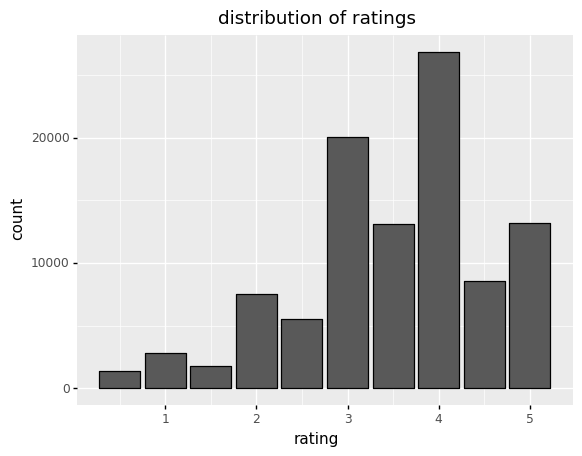

<ggplot: (8754170554109)>

In [12]:
(
    ggplot(movielens, aes(x="rating"))
    + geom_bar(color="black")
    + labs(x="rating", title="distribution of ratings")
)

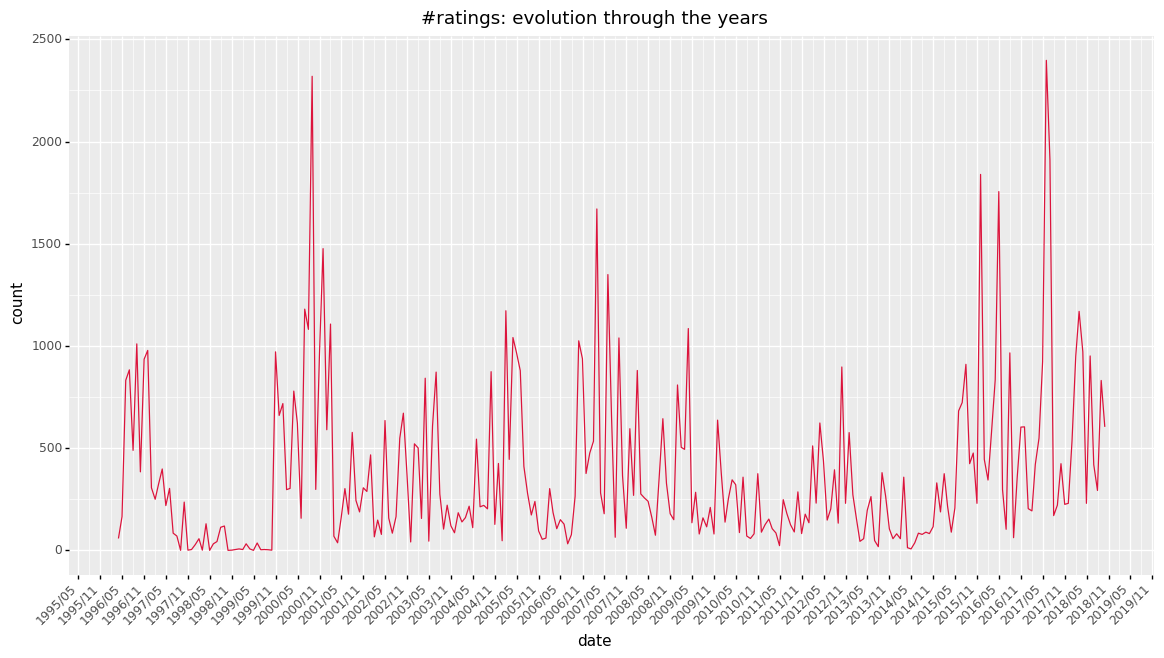

<ggplot: (8754051888300)>

In [13]:
(
    ggplot(
        movielens.groupby(pd.Grouper(key="created_at", freq="M")).count().reset_index()
    )
    + geom_line(aes(x="created_at", y="item"), color="crimson")
    + labs(x="date", y="count", title="#ratings: evolution through the years")
    + scale_x_datetime(breaks=date_breaks("6 months"), labels=date_format("%Y/%m"))
    + theme(axis_text_x=element_text(rotation=45, hjust=1), figure_size=(14, 7))
)

## Step 4

In [14]:
recsys_small = SVD(
    n_factors=4,
    n_epochs=50,
    biased=True,  # use baselines
    random_state=123456,
)

In [15]:
recsys_large = SVD(
    n_factors=20,
    n_epochs=50,
    biased=True,  # use baselines
    random_state=123456,
)

In [16]:
cv_results = {}

cv_results["SVD w/ 4 factors"] = cross_validate(
    recsys_small,
    data=data,
    measures=["mse", "rmse", "mae"],
    return_train_measures=True,
    verbose=True,
    cv=5,
    n_jobs=-1,
)

Evaluating MSE, RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MSE (testset)     0.7610  0.7554  0.7754  0.7739  0.7807  0.7693  0.0095  
RMSE (testset)    0.8723  0.8691  0.8805  0.8797  0.8836  0.8771  0.0054  
MAE (testset)     0.6677  0.6666  0.6747  0.6728  0.6765  0.6716  0.0039  
MSE (trainset)    0.5103  0.5211  0.5162  0.5247  0.5176  0.5180  0.0048  
RMSE (trainset)   0.7143  0.7219  0.7185  0.7244  0.7194  0.7197  0.0034  
MAE (trainset)    0.5486  0.5557  0.5540  0.5575  0.5542  0.5540  0.0030  
Fit time          1.83    1.89    1.87    1.79    1.81    1.84    0.04    
Test time         0.10    0.10    0.11    0.10    0.10    0.10    0.00    


In [17]:
cv_results["SVD w/ 20 factors"] = cross_validate(
    recsys_large,
    data=data,
    measures=["mse", "rmse", "mae"],
    return_train_measures=True,
    verbose=True,
    cv=5,
    n_jobs=-1,
)

Evaluating MSE, RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MSE (testset)     0.7804  0.7960  0.7890  0.7904  0.7723  0.7856  0.0083  
RMSE (testset)    0.8834  0.8922  0.8882  0.8890  0.8788  0.8863  0.0047  
MAE (testset)     0.6764  0.6804  0.6788  0.6770  0.6734  0.6772  0.0024  
MSE (trainset)    0.3071  0.3020  0.3063  0.3052  0.3044  0.3050  0.0018  
RMSE (trainset)   0.5542  0.5496  0.5535  0.5524  0.5517  0.5523  0.0016  
MAE (trainset)    0.4275  0.4241  0.4271  0.4254  0.4255  0.4259  0.0012  
Fit time          3.16    3.21    3.19    3.16    3.15    3.17    0.02    
Test time         0.10    0.09    0.11    0.10    0.10    0.10    0.00    


In [18]:
df = pd.DataFrame(cv_results).T.reset_index()

df["mean RMSE (train)"] = df["train_rmse"].map(lambda x: statistics.mean(x))
df["mean RMSE (test)"] = df["test_rmse"].map(lambda x: statistics.mean(x))

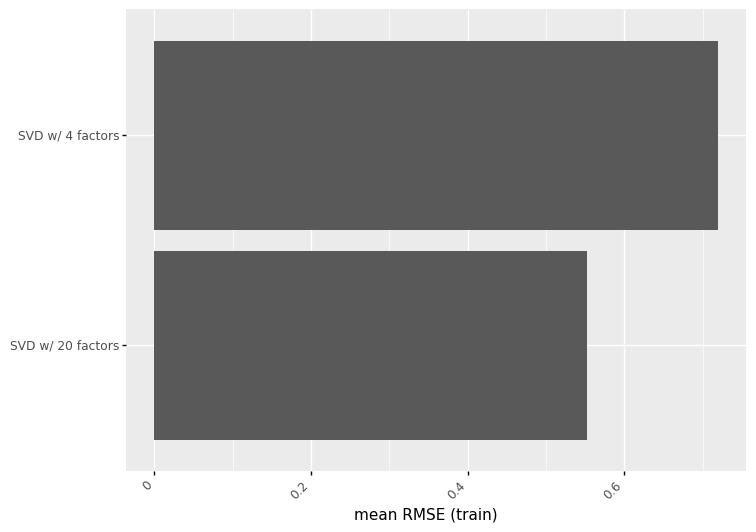

<ggplot: (8754048923859)>

In [19]:
(
    ggplot(df)
    + geom_col(aes(x="index", y="mean RMSE (train)"), stat="identity")
    + theme(axis_text_x=element_text(rotation=45, hjust=1), figure_size=(8, 6))
    + labs(x="", y="mean RMSE (train)")
    + coord_flip()
)

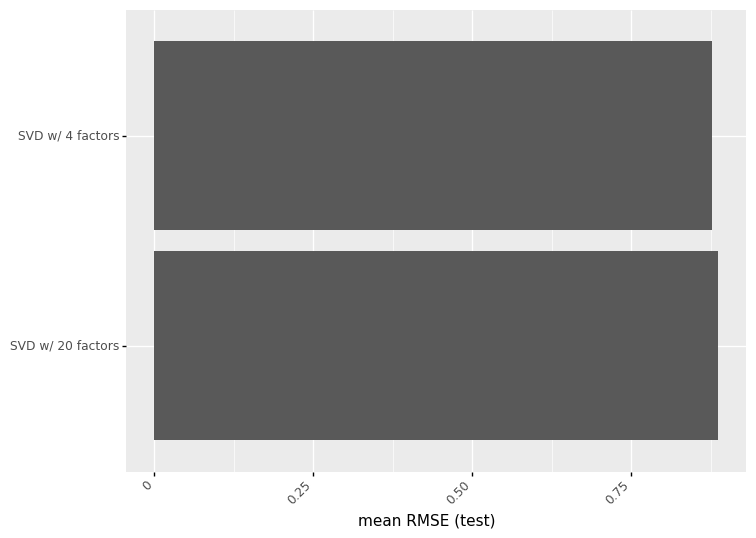

<ggplot: (8754161456381)>

In [20]:
(
    ggplot(df)
    + geom_col(aes(x="index", y="mean RMSE (test)"), stat="identity")
    + theme(axis_text_x=element_text(rotation=45, hjust=1), figure_size=(8, 6))
    + labs(x="", y="mean RMSE (test)")
    + coord_flip()
)

## Step 5

In [21]:
ratings = pd.read_csv(
    "data/ml-latest-small/ratings.csv",
    usecols=["user", "item", "rating"],
    names=["user", "item", "rating"],
    skiprows=1,
)

inspect_df(ratings)

shape: (100836, 3)


,user,item,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [22]:
ratings["user"] = ratings.groupby("user").ngroup()

In [23]:
ratings["item"] = ratings.groupby("item").ngroup()

In [24]:
def transform_batch(batch: tf.Tensor) -> collections.OrderedDict:
    return collections.OrderedDict(
        x=tf.cast(batch[:, 0:2], tf.int64), y=tf.cast(batch[:, 2:3], tf.float32)
    )

In [25]:
def create_tf_datasets(
    data: pd.DataFrame,
    transform_func: Callable,
    batch_size: int = 1,
    max_clients: int = None,
    max_items_per_client: int = None,
) -> Iterator[tf.data.Dataset]:

    n_users = len(data["user"].unique())

    if max_clients is not None:
        n_users = min(n_users, max_clients)

    for _, user_ratings in data.groupby("user"):

        if n_users < 0:
            break

        tf_dataset = tf.data.Dataset.from_tensor_slices(user_ratings)

        yield (
            tf_dataset.take(max_items_per_client)
            .shuffle(buffer_size=max_items_per_client, seed=42)
            .batch(batch_size)
            .map(transform_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        )

        n_users -= 1

In [26]:
def split_tf_datasets(
    tf_datasets: List[tf.data.Dataset],
    train_fraction: float = 0.8,
    val_fraction: float = 0.1,
) -> Tuple[List[tf.data.Dataset], List[tf.data.Dataset], List[tf.data.Dataset]]:
    """Splits a list of user TF datasets into train/val/test by user."""
    np.random.seed(42)
    np.random.shuffle(tf_datasets)

    train_idx = int(len(tf_datasets) * train_fraction)
    val_idx = int(len(tf_datasets) * (train_fraction + val_fraction))

    # Note that the val and test data contains completely different users, not
    # just unseen ratings from train users.
    return (
        tf_datasets[:train_idx],
        tf_datasets[train_idx:val_idx],
        tf_datasets[val_idx:],
    )

In [27]:
tf_datasets = [
    *create_tf_datasets(
        data=ratings,
        transform_func=transform_batch,
        batch_size=10,
        max_clients=100,
        max_items_per_client=3000,
    )
]

In [28]:
tf_trainsets, tf_validationsets, tf_testsets = split_tf_datasets(
    tf_datasets, train_fraction=0.8, val_fraction=0.1
)

## Step 6

In [29]:
nest_asyncio.apply()

In [30]:
n_users = len(ratings["user"].unique())
n_items = len(ratings["item"].unique())

In [31]:
def matrix_factorization_model(
    n_users: int,
    n_items: int,
    n_latent_factors: int,
) -> tf.keras.Model:
    """A federation-friendly Matrix Factorization model."""
    combined_input = tf.keras.layers.Input(
        shape=[2], dtype="int32", name="combined_input"
    )
    u = tf.keras.layers.Embedding(
        input_dim=n_users + 1, output_dim=n_latent_factors, name="users_embedding"
    )(combined_input[:, 0])
    u = tf.keras.layers.Flatten()(u)

    i = tf.keras.layers.Embedding(
        input_dim=n_items + 1, output_dim=n_latent_factors, name="items_embedding"
    )(combined_input[:, 1])
    i = tf.keras.layers.Flatten()(i)

    output = tf.output_layer = tf.keras.layers.Dot(1, normalize=False, name="Dot")(
        [i, u]
    )

    model = tf.keras.Model(inputs=combined_input, outputs=output)

    input_spec = collections.OrderedDict(
        x=tf.TensorSpec(shape=[None, 2], dtype=tf.int64),
        y=tf.TensorSpec(shape=[None, 1], dtype=tf.float32),
    )

    return tff.learning.from_keras_model(
        model,
        input_spec=input_spec,
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.RootMeanSquaredError()],
    )

In [32]:
model_fn = functools.partial(
    matrix_factorization_model,
    n_users=n_users,
    n_items=n_items,
    n_latent_factors=4,
)

In [33]:
iterative_process = tff.learning.build_federated_averaging_process(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.02),
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=1.0),
)

In [34]:
print(iterative_process.initialize.type_signature.formatted_representation())

( -> <
  model=<
    trainable=<
      float32[9725,4],
      float32[611,4]
    >,
    non_trainable=<>
  >,
  optimizer_state=<
    int64
  >,
  delta_aggregate_state=<
    value_sum_process=<>,
    weight_sum_process=<>
  >,
  model_broadcast_state=<>
>@SERVER)


In [35]:
state = iterative_process.initialize()

print(state.model)

ModelWeights(trainable=[array([[ 0.02181235, -0.00231989, -0.04725677, -0.01953872],
       [-0.00454887, -0.01104885, -0.01189889,  0.01323474],
       [ 0.02487737, -0.02631809,  0.00163212, -0.01756128],
       ...,
       [-0.01855221, -0.02875171,  0.01940593, -0.00376754],
       [ 0.00901536,  0.04960806,  0.04624451,  0.03371528],
       [ 0.0445102 ,  0.02682657,  0.02888374,  0.04349072]],
      dtype=float32), array([[-0.02605475, -0.00180398,  0.00619038, -0.01216256],
       [-0.0462975 ,  0.04843486, -0.00867862, -0.04493898],
       [ 0.01447196, -0.04925039,  0.04180572,  0.0436664 ],
       ...,
       [-0.02613701, -0.03449138,  0.00030027,  0.00295358],
       [-0.02527305, -0.04431795,  0.00088827,  0.02080953],
       [-0.03733126,  0.01437435, -0.04561872,  0.02510503]],
      dtype=float32)], non_trainable=[])


In [36]:
print("User variables shape:", state.model.trainable[1].shape)

User variables shape: (611, 4)


In [37]:
print("Item variables shape:", state.model.trainable[0].shape)

Item variables shape: (9725, 4)


In [38]:
evaluation_computation = tff.learning.build_federated_evaluation(model_fn)

In [39]:
print(evaluation_computation.type_signature.formatted_representation())

(<
  server_model_weights=<
    trainable=<
      float32[9725,4],
      float32[611,4]
    >,
    non_trainable=<>
  >@SERVER,
  federated_dataset={<
    x=int64[?,2],
    y=float32[?,1]
  >*}@CLIENTS
> -> <
  eval=<
    root_mean_squared_error=float32,
    loss=float32,
    num_examples=int64,
    num_batches=int64
  >
>@SERVER)


In [40]:
NUM_ROUNDS = 30  # we will set up a training loop to train over multiple rounds.

In [41]:
train_losses, train_accs = [], []

state = iterative_process.initialize()

for i in range(NUM_ROUNDS):
    federated_train_data = np.random.choice(
        tf_trainsets, size=50, replace=False
    ).tolist()
    state, metrics = iterative_process.next(state, federated_train_data)
    print(f"Train round {i}:", metrics["train"])
    train_losses.append(metrics["train"]["loss"])
    train_accs.append(metrics["train"]["root_mean_squared_error"])

Train round 0: OrderedDict([('root_mean_squared_error', 3.6591785), ('loss', 13.389588), ('num_examples', 8644), ('num_batches', 888)])
Train round 1: OrderedDict([('root_mean_squared_error', 3.6203663), ('loss', 13.107053), ('num_examples', 8908), ('num_batches', 917)])
Train round 2: OrderedDict([('root_mean_squared_error', 3.6475594), ('loss', 13.30469), ('num_examples', 9100), ('num_batches', 932)])
Train round 3: OrderedDict([('root_mean_squared_error', 3.6928442), ('loss', 13.637098), ('num_examples', 7853), ('num_batches', 811)])
Train round 4: OrderedDict([('root_mean_squared_error', 3.622378), ('loss', 13.121623), ('num_examples', 9232), ('num_batches', 947)])
Train round 5: OrderedDict([('root_mean_squared_error', 3.6822867), ('loss', 13.559237), ('num_examples', 8628), ('num_batches', 887)])
Train round 6: OrderedDict([('root_mean_squared_error', 3.7148118), ('loss', 13.799828), ('num_examples', 9198), ('num_batches', 943)])
Train round 7: OrderedDict([('root_mean_squared_er

2022-03-20 23:08:33.807214: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


Train round 27: OrderedDict([('root_mean_squared_error', 3.8016074), ('loss', 14.452219), ('num_examples', 6879), ('num_batches', 711)])
Train round 28: OrderedDict([('root_mean_squared_error', 3.6548963), ('loss', 13.358266), ('num_examples', 9590), ('num_batches', 983)])
Train round 29: OrderedDict([('root_mean_squared_error', 3.7020292), ('loss', 13.705021), ('num_examples', 8166), ('num_batches', 842)])


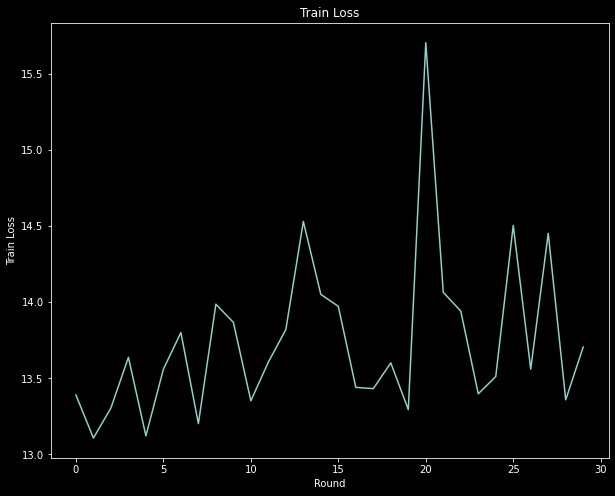

In [42]:
plt.style.use("dark_background")
plt.rcParams["figure.figsize"] = [10, 8]
plt.plot(range(NUM_ROUNDS), train_losses)
plt.ylabel("Train Loss")
plt.xlabel("Round")
plt.title("Train Loss")
plt.show()

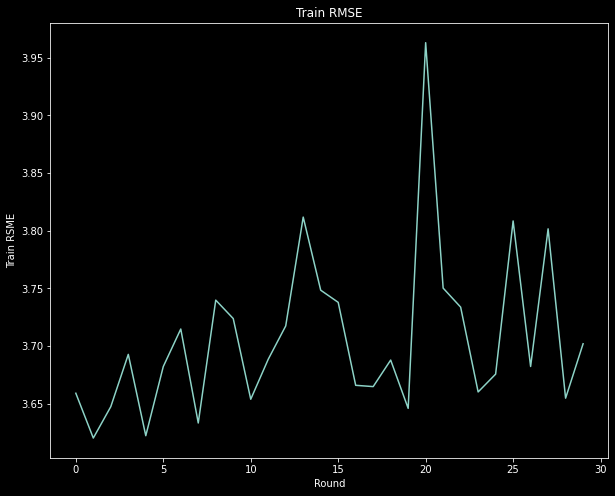

In [43]:
plt.style.use("dark_background")
plt.rcParams["figure.figsize"] = [10, 8]
plt.plot(range(NUM_ROUNDS), train_accs)
plt.ylabel("Train RSME")
plt.xlabel("Round")
plt.title("Train RMSE")
plt.show()

In [44]:
eval_metrics = evaluation_computation(state.model, tf_validationsets)
print("Final Eval:", eval_metrics["eval"])

Final Eval: OrderedDict([('root_mean_squared_error', 3.7561028), ('loss', 14.108308), ('num_examples', 1038), ('num_batches', 106)])


In [45]:
eval_metrics = evaluation_computation(state.model, tf_testsets)
print("Final Test:", eval_metrics["eval"])

Final Test: OrderedDict([('root_mean_squared_error', 3.8080592), ('loss', 14.501315), ('num_examples', 1301), ('num_batches', 134)])


## Step 7

In [46]:
def transform_batch_for_fed_prox(batch: tf.Tensor) -> collections.OrderedDict:
    """we do not need the user since each client will only look at their own data."""
    return collections.OrderedDict(
        x=tf.cast(batch[:, 1:2], tf.int64), y=tf.cast(batch[:, 2:3], tf.float32)
    )

In [47]:
tf_datasets = [
    *create_tf_datasets(
        data=ratings,
        transform_func=transform_batch_for_fed_prox,
        batch_size=10,
        max_clients=100,
        max_items_per_client=3000,
    )
]

In [48]:
tf_trainsets, tf_validationsets, tf_testsets = split_tf_datasets(
    tf_datasets, train_fraction=0.8, val_fraction=0.1
)

In [49]:
class UserEmbedding(tf.keras.layers.Layer):
    """Keras layer representing an embedding for a single user."""

    def __init__(self, num_latent_factors, **kwargs):
        super().__init__(**kwargs)
        self.num_latent_factors = num_latent_factors

    def build(self, input_shape):
        self.embedding = self.add_weight(
            shape=(1, self.num_latent_factors),
            initializer="uniform",
            dtype=tf.float32,
            name="UserEmbeddingKernel",
        )
        super().build(input_shape)

    def call(self, inputs):
        return self.embedding

    def compute_output_shape(self):
        return (1, self.num_latent_factors)

In [50]:
def matrix_factorization_model_with_user_embedding(
    n_items: int, n_latent_factors: int
) -> tff.learning.Model:

    item_input = tf.keras.layers.Input(shape=[1], name="Item")
    item_embedding_layer = tf.keras.layers.Embedding(
        n_items, n_latent_factors, name="ItemEmbedding"
    )
    flat_item_vec = tf.keras.layers.Flatten(name="FlattenItems")(
        item_embedding_layer(item_input)
    )

    user_embedding_layer = UserEmbedding(n_latent_factors, name="UserEmbedding")

    flat_user_vec = user_embedding_layer(item_input)

    pred = tf.keras.layers.Dot(1, normalize=False, name="Dot")(
        [flat_user_vec, flat_item_vec]
    )

    input_spec = collections.OrderedDict(
        x=tf.TensorSpec(shape=[None, 1], dtype=tf.int64),
        y=tf.TensorSpec(shape=[None, 1], dtype=tf.float32),
    )

    model = tf.keras.Model(inputs=item_input, outputs=pred)

    return tff.learning.from_keras_model(
        model,
        input_spec=input_spec,
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.RootMeanSquaredError()],
    )

In [51]:
model_fn = functools.partial(
    matrix_factorization_model_with_user_embedding,
    n_items=n_items,
    n_latent_factors=4,
)

In [52]:
fedprox_learning_process = tff.learning.algorithms.build_unweighted_fed_prox(
    model_fn,
    proximal_strength=0.15,
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(1.0),
    client_optimizer_fn=lambda: tf.keras.optimizers.SGD(0.5),
)

/home/iantonopoulos/.cache/pypoetry/virtualenvs/recommender-systems-rVb3Y5Fg-py3.8/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("PartitionedCall:2", shape=(None,), dtype=int32), values=Tensor("PartitionedCall:1", shape=(None, 4), dtype=float32), dense_shape=Tensor("PartitionedCall:3", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.


In [53]:
print(fedprox_learning_process.initialize.type_signature.formatted_representation())

( -> <
  global_model_weights=<
    trainable=<
      float32[9724,4],
      float32[1,4]
    >,
    non_trainable=<>
  >,
  distributor=<>,
  client_work=<>,
  aggregator=<
    <>,
    <>
  >,
  finalizer=<
    int64
  >
>@SERVER)


In [54]:
evaluation_computation = tff.learning.build_federated_evaluation(
    model_fn,
)

In [55]:
print(evaluation_computation.type_signature.formatted_representation())

(<
  server_model_weights=<
    trainable=<
      float32[9724,4],
      float32[1,4]
    >,
    non_trainable=<>
  >@SERVER,
  federated_dataset={<
    x=int64[?,1],
    y=float32[?,1]
  >*}@CLIENTS
> -> <
  eval=<
    root_mean_squared_error=float32,
    loss=float32,
    num_examples=int64,
    num_batches=int64
  >
>@SERVER)


In [56]:
train_losses, train_rmses = [], []

state = fedprox_learning_process.initialize()

# This may take a couple minutes to run.
for i in range(NUM_ROUNDS):
    federated_train_data = np.random.choice(
        tf_trainsets, size=50, replace=False
    ).tolist()
    next_state = fedprox_learning_process.next(state, federated_train_data)
    train_losses.append(next_state.metrics["client_work"]["train"]["loss"])
    train_rmses.append(
        next_state.metrics["client_work"]["train"]["root_mean_squared_error"]
    )

model_final_weights = next_state.state.global_model_weights

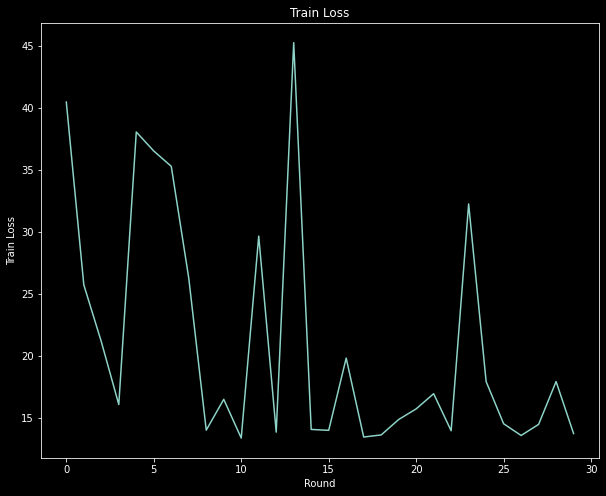

In [57]:
plt.style.use("dark_background")
plt.rcParams["figure.figsize"] = [10, 8]
plt.plot(range(NUM_ROUNDS), train_losses)
plt.ylabel("Train Loss")
plt.xlabel("Round")
plt.title("Train Loss")
plt.show()

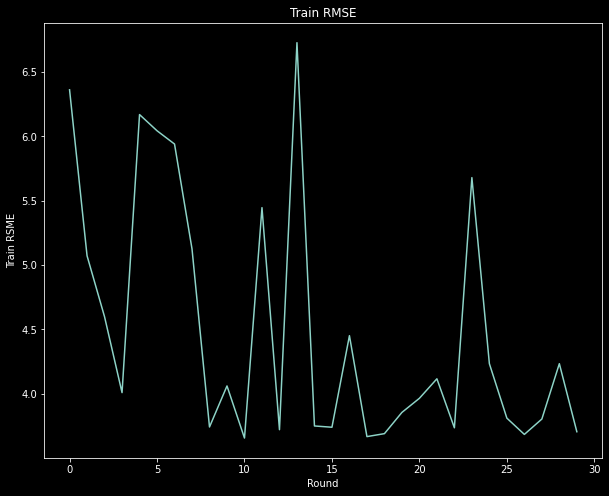

In [58]:
plt.style.use("dark_background")
plt.rcParams["figure.figsize"] = [10, 8]
plt.plot(range(NUM_ROUNDS), train_rmses)
plt.ylabel("Train RSME")
plt.xlabel("Round")
plt.title("Train RMSE")
plt.show()

In [59]:
eval_metrics = evaluation_computation(model_final_weights, tf_validationsets)
print("Final Eval:", eval_metrics["eval"])

Final Eval: OrderedDict([('root_mean_squared_error', 3.7435942), ('loss', 14.014498), ('num_examples', 1038), ('num_batches', 106)])


In [60]:
eval_metrics = evaluation_computation(model_final_weights, tf_testsets)
print("Final Test:", eval_metrics["eval"])

Final Test: OrderedDict([('root_mean_squared_error', 3.7939317), ('loss', 14.393919), ('num_examples', 1301), ('num_batches', 134)])


## Step 8

In [61]:
def get_matrix_factorization_reconstruction_model(
    n_items: int, n_latent_factors: int
) -> tff.learning.reconstruction.Model:
    """Defines a Keras matrix factorization model."""
    # layers with variables will be partitioned into global and local layers.
    global_layers = []
    local_layers = []

    item_input = tf.keras.layers.Input(shape=[1], name="Item")
    item_embedding_layer = tf.keras.layers.Embedding(
        n_items, n_latent_factors, name="ItemEmbedding"
    )
    global_layers.append(item_embedding_layer)
    flat_item_vec = tf.keras.layers.Flatten(name="FlattenItems")(
        item_embedding_layer(item_input)
    )

    user_embedding_layer = UserEmbedding(n_latent_factors, name="UserEmbedding")
    local_layers.append(user_embedding_layer)

    flat_user_vec = user_embedding_layer(item_input)

    pred = tf.keras.layers.Dot(1, normalize=False, name="Dot")(
        [flat_user_vec, flat_item_vec]
    )

    input_spec = collections.OrderedDict(
        x=tf.TensorSpec(shape=[None, 1], dtype=tf.int64),
        y=tf.TensorSpec(shape=[None, 1], dtype=tf.float32),
    )

    model = tf.keras.Model(inputs=item_input, outputs=pred)

    return tff.learning.reconstruction.from_keras_model(
        keras_model=model,
        global_layers=global_layers,
        local_layers=local_layers,
        input_spec=input_spec,
    )

In [62]:
model_fn = functools.partial(
    get_matrix_factorization_reconstruction_model, n_items=n_items, n_latent_factors=4
)

In [63]:
class RatingAccuracy(tf.keras.metrics.Mean):
    """Keras metric computing accuracy of reconstructed ratings."""

    def __init__(self, name: str = "rating_accuracy", **kwargs):
        super().__init__(name=name, **kwargs)

    def update_state(
        self,
        y_true: tf.Tensor,
        y_pred: tf.Tensor,
        sample_weight: Optional[tf.Tensor] = None,
    ):
        absolute_diffs = tf.abs(y_true - y_pred)
        # A [batch_size, 1] tf.bool tensor indicating correctness within the
        # threshold for each example in a batch. A 0.5 threshold corresponds
        # to correctness when predictions are rounded to the nearest whole
        # number.
        example_accuracies = tf.less_equal(absolute_diffs, 0.5)
        super().update_state(example_accuracies, sample_weight=sample_weight)

In [64]:
loss_fn = lambda: tf.keras.losses.MeanSquaredError()
metrics_fn = lambda: [RatingAccuracy(), tf.keras.metrics.RootMeanSquaredError()]

In [65]:
training_process = tff.learning.reconstruction.build_training_process(
    model_fn=model_fn,
    loss_fn=loss_fn,
    metrics_fn=metrics_fn,
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(1.0),
    client_optimizer_fn=lambda: tf.keras.optimizers.SGD(0.5),
    reconstruction_optimizer_fn=lambda: tf.keras.optimizers.SGD(0.1),
)

In [66]:
print(training_process.initialize.type_signature.formatted_representation())

( -> <
  model=<
    trainable=<
      float32[9724,4]
    >,
    non_trainable=<>
  >,
  optimizer_state=<
    int64
  >,
  delta_aggregate_state=<
    value_sum_process=<>,
    weight_sum_process=<>
  >,
  model_broadcast_state=<>
>@SERVER)


In [67]:
evaluation_computation = tff.learning.reconstruction.build_federated_evaluation(
    model_fn,
    loss_fn=loss_fn,
    metrics_fn=metrics_fn,
    reconstruction_optimizer_fn=functools.partial(tf.keras.optimizers.SGD, 0.1),
)

In [68]:
print(evaluation_computation.type_signature.formatted_representation())

(<
  server_model_weights=<
    trainable=<
      float32[9724,4]
    >,
    non_trainable=<>
  >@SERVER,
  federated_dataset={<
    x=int64[?,1],
    y=float32[?,1]
  >*}@CLIENTS
> -> <
  broadcast=<>,
  eval=<
    loss=float32,
    rating_accuracy=float32,
    root_mean_squared_error=float32
  >
>@SERVER)


In [69]:
state = training_process.initialize()

print(state.model)

ModelWeights(trainable=[array([[-0.02420468, -0.0481894 , -0.02117388,  0.04073622],
       [-0.01902798,  0.00317962, -0.03580298,  0.03281731],
       [-0.03863446,  0.03684492, -0.02713155, -0.04496428],
       ...,
       [-0.0257534 , -0.04881522,  0.04319967, -0.00650786],
       [-0.04508336,  0.00071261, -0.01372782,  0.01605055],
       [ 0.00808473, -0.02884355,  0.036666  , -0.03525789]],
      dtype=float32)], non_trainable=[])


In [70]:
print("Item variables shape:", state.model.trainable[0].shape)

Item variables shape: (9724, 4)


In [71]:
eval_metrics = evaluation_computation(state.model, tf_validationsets)

In [72]:
print("Initial Eval:", eval_metrics["eval"])

Initial Eval: OrderedDict([('loss', 13.991703), ('rating_accuracy', 0.028169014), ('root_mean_squared_error', 3.7405484)])


In [73]:
federated_train_data = np.random.choice(tf_trainsets, size=50, replace=False).tolist()
state, metrics = training_process.next(state, federated_train_data)

In [74]:
print(f"Train metrics:", metrics["train"])

Train metrics: OrderedDict([('rating_accuracy', 0.0040757614), ('root_mean_squared_error', 3.5965424), ('loss', 12.935118)])


In [75]:
train_losses, train_accs, train_rmses = [], [], []

state = training_process.initialize()

# This may take a couple minutes to run.
for i in range(NUM_ROUNDS):
    federated_train_data = np.random.choice(
        tf_trainsets, size=50, replace=False
    ).tolist()
    state, metrics = training_process.next(state, federated_train_data)
    print(f"Train round {i}:", metrics["train"])
    train_losses.append(metrics["train"]["loss"])
    train_accs.append(metrics["train"]["rating_accuracy"])
    train_rmses.append(metrics["train"]["root_mean_squared_error"])

Train round 0: OrderedDict([('rating_accuracy', 0.0031684134), ('root_mean_squared_error', 3.6937685), ('loss', 13.643927)])
Train round 1: OrderedDict([('rating_accuracy', 0.0051491098), ('root_mean_squared_error', 3.6776881), ('loss', 13.52539)])


2022-03-20 23:11:17.584776: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


Train round 2: OrderedDict([('rating_accuracy', 0.0070601525), ('root_mean_squared_error', 3.6533492), ('loss', 13.34696)])
Train round 3: OrderedDict([('rating_accuracy', 0.007959671), ('root_mean_squared_error', 3.777476), ('loss', 14.269325)])
Train round 4: OrderedDict([('rating_accuracy', 0.0060266894), ('root_mean_squared_error', 3.629937), ('loss', 13.176442)])
Train round 5: OrderedDict([('rating_accuracy', 0.0073660146), ('root_mean_squared_error', 3.7638085), ('loss', 14.166255)])
Train round 6: OrderedDict([('rating_accuracy', 0.0059339525), ('root_mean_squared_error', 3.6862743), ('loss', 13.588618)])
Train round 7: OrderedDict([('rating_accuracy', 0.012198428), ('root_mean_squared_error', 3.5404673), ('loss', 12.534909)])
Train round 8: OrderedDict([('rating_accuracy', 0.008588957), ('root_mean_squared_error', 3.5184991), ('loss', 12.379836)])
Train round 9: OrderedDict([('rating_accuracy', 0.040306557), ('root_mean_squared_error', 3.230118), ('loss', 10.433663)])


2022-03-20 23:11:57.375237: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


Train round 10: OrderedDict([('rating_accuracy', 0.11148731), ('root_mean_squared_error', 2.7610483), ('loss', 7.6233873)])
Train round 11: OrderedDict([('rating_accuracy', 0.075192094), ('root_mean_squared_error', 2.7180667), ('loss', 7.387887)])
Train round 12: OrderedDict([('rating_accuracy', 0.14618973), ('root_mean_squared_error', 2.5622654), ('loss', 6.5652046)])
Train round 13: OrderedDict([('rating_accuracy', 0.16992512), ('root_mean_squared_error', 2.3490753), ('loss', 5.5181556)])
Train round 14: OrderedDict([('rating_accuracy', 0.11567905), ('root_mean_squared_error', 2.4472487), ('loss', 5.989026)])
Train round 15: OrderedDict([('rating_accuracy', 0.185471), ('root_mean_squared_error', 2.3607628), ('loss', 5.573201)])
Train round 16: OrderedDict([('rating_accuracy', 0.20482509), ('root_mean_squared_error', 2.2579432), ('loss', 5.098307)])
Train round 17: OrderedDict([('rating_accuracy', 0.13071896), ('root_mean_squared_error', 2.3938873), ('loss', 5.730696)])
Train round 18

2022-03-20 23:12:50.141467: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


Train round 20: OrderedDict([('rating_accuracy', 0.26459628), ('root_mean_squared_error', 1.9418553), ('loss', 3.7708023)])
Train round 21: OrderedDict([('rating_accuracy', 0.19327527), ('root_mean_squared_error', 2.0353937), ('loss', 4.1428275)])
Train round 22: OrderedDict([('rating_accuracy', 0.28875533), ('root_mean_squared_error', 1.7942115), ('loss', 3.2191954)])
Train round 23: OrderedDict([('rating_accuracy', 0.20343605), ('root_mean_squared_error', 2.0175242), ('loss', 4.070404)])
Train round 24: OrderedDict([('rating_accuracy', 0.2560331), ('root_mean_squared_error', 1.883555), ('loss', 3.5477798)])
Train round 25: OrderedDict([('rating_accuracy', 0.26701948), ('root_mean_squared_error', 1.8291265), ('loss', 3.3457038)])
Train round 26: OrderedDict([('rating_accuracy', 0.2940531), ('root_mean_squared_error', 1.7133677), ('loss', 2.935629)])


2022-03-20 23:13:23.831235: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


Train round 27: OrderedDict([('rating_accuracy', 0.19214109), ('root_mean_squared_error', 1.9719234), ('loss', 3.8884816)])
Train round 28: OrderedDict([('rating_accuracy', 0.24713244), ('root_mean_squared_error', 1.7337683), ('loss', 3.0059528)])


2022-03-20 23:13:34.395508: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


Train round 29: OrderedDict([('rating_accuracy', 0.2328963), ('root_mean_squared_error', 1.7672924), ('loss', 3.1233222)])


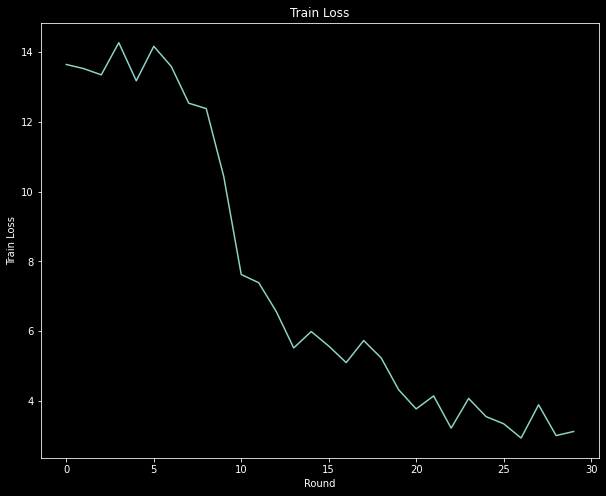

In [76]:
plt.style.use("dark_background")
plt.rcParams["figure.figsize"] = [10, 8]
plt.plot(range(NUM_ROUNDS), train_losses)
plt.ylabel("Train Loss")
plt.xlabel("Round")
plt.title("Train Loss")
plt.show()

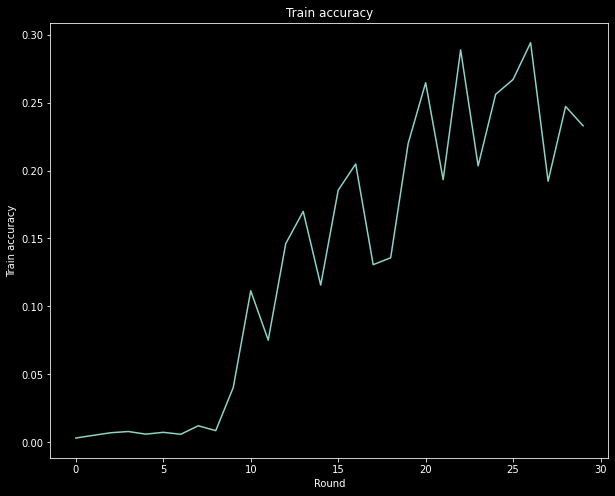

In [77]:
plt.plot(range(NUM_ROUNDS), train_accs)
plt.ylabel("Train accuracy")
plt.xlabel("Round")
plt.title("Train accuracy")
plt.show()

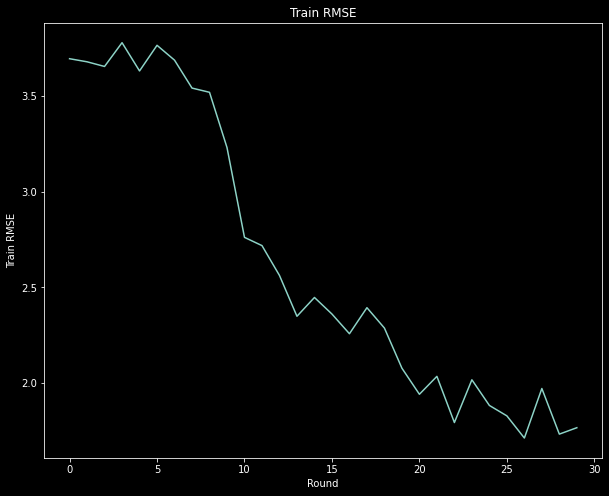

In [78]:
plt.plot(range(NUM_ROUNDS), train_rmses)
plt.ylabel("Train RMSE")
plt.xlabel("Round")
plt.title("Train RMSE")
plt.show()

In [79]:
eval_metrics = evaluation_computation(state.model, tf_validationsets)
print("Final Eval:", eval_metrics["eval"])

Final Eval: OrderedDict([('loss', 4.3455544), ('rating_accuracy', 0.25955734), ('root_mean_squared_error', 2.0845993)])


In [80]:
eval_metrics = evaluation_computation(state.model, tf_testsets)
print("Final Test:", eval_metrics["eval"])

Final Test: OrderedDict([('loss', 4.6532607), ('rating_accuracy', 0.1168), ('root_mean_squared_error', 2.1571417)])


## Step 9

In [81]:
# already incorporated in previous steps

## Step 10